In [1]:
!pip install transformers==3

     |████████████████████████████████| 757kB 11.0MB/s 
     |████████████████████████████████| 1.2MB 23.0MB/s 
     |████████████████████████████████| 901kB 37.4MB/s 
     |████████████████████████████████| 3.0MB 35.3MB/s 


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# Use GPU
device = torch.device("cuda")

In [3]:
df = pd.read_csv("Harassment_Cleaned_tweets.csv")
df.head()

,Unnamed: 0,Key Word,Username,User_ID,Datetime,Favorite_count,Geo,Coordinates,Label,Text,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,704,ass,DeborahParr,1.330000e+18,11-11-2020 06:56,0,NaN,NaN,1,He’d have my phone wedged up his ass sideways.,NaN,NaN,NaN
1,1915,boobies,MaxZorin85,1.330000e+18,11-11-2020 07:35,4,NaN,NaN,0,Yep 100% agree and the same with severine in s...,NaN,NaN,NaN
2,2856,eat pussy,PRISJ1_,1.330000e+18,11-11-2020 10:36,0,NaN,NaN,1,Stop having sex with men that won’t eat your p...,NaN,NaN,NaN
3,2163,Breast Man,Teresamckenzy1,1.330000e+18,10-11-2020 20:52,0,NaN,NaN,1,"When you see a sad man, just give him breast t...",NaN,NaN,NaN
4,2852,eat pussy,sj__vazquez,1.330000e+18,11-11-2020 10:42,0,NaN,NaN,1,We can't be together if you don't eat pussy,NaN,NaN,NaN


In [4]:
# Displaying Class distribution
df['Label'].value_counts(normalize = True)

1    0.547447
0    0.452553
Name: Label, dtype: float64

In [5]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['Text'], df['Label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.2, 
                                                                    stratify=df['Label'])

# Using temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.1, 
                                                                stratify=temp_labels)

In [6]:
# Importing BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [7]:
# Sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# Encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

# Output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


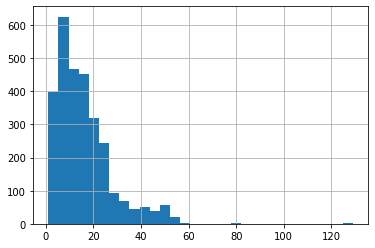

In [8]:
# Getting length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [9]:
max_seq_len = 25
# Tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# Tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# Tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

In [10]:
# Converting Integer Sequences to Tensor

# For train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# For validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# For test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [11]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Define a batch size
batch_size = 32

# Wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# Sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# DataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# Sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# DataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)


In [12]:
# Freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [13]:
# Model Architecture

class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # Dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # Relu activation function
      self.relu =  nn.ReLU()

      # Dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # Dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      # Softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    # Define the forward pass
    def forward(self, sent_id, mask):

      # Pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # Output layer
      x = self.fc2(x)
      
      # Apply softmax activation
      x = self.softmax(x)

      return x

In [14]:
# Pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# Push the model to GPU
model = model.to(device)
print (device)

cuda


In [15]:
# Optimizer from hugging face transformers
from transformers import AdamW

# Define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

In [16]:
# Finding class weights

from sklearn.utils.class_weight import compute_class_weight

# Compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[1.1045977 0.9134981]


In [17]:
# Convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# Loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# Number of training epochs
epochs = 10


In [18]:
# Function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # Empty list to save model predictions
  total_preds=[]
  
  # Iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # Progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # Push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # Clear previously calculated gradients 
    model.zero_grad()        

    # Get model predictions for the current batch
    preds = model(sent_id, mask)

    # Compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # Add on to the total loss
    total_loss = total_loss + loss.item()

    # Backward pass to calculate the gradients
    loss.backward()

    # Clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters
    optimizer.step()

    # Model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # Append the model predictions
    total_preds.append(preds)

  # Compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # Predictions are in the form of (no. of batches, size of batch, no. of classes).
  # Reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  # Returns the loss and predictions
  return avg_loss, total_preds

In [19]:
# Function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # Deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # Empty list to save the model predictions
  total_preds = []

  # Iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # Push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # Deactivate autograd
    with torch.no_grad():
      
      # Model predictions
      preds = model(sent_id, mask)

      # Compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # Compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # Reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [20]:
# Set initial loss to infinite
best_valid_loss = float('inf')

# Empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

# For each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    # Train model
    train_loss, _ = train()
    
    # Evaluate model
    valid_loss, _ = evaluate()
    
    # Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # Append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of     91.

Evaluating...

Training Loss: 0.709
Validation Loss: 0.669

 Epoch 2 / 10
  Batch    50  of     91.

Evaluating...

Training Loss: 0.692
Validation Loss: 0.667

 Epoch 3 / 10
  Batch    50  of     91.

Evaluating...

Training Loss: 0.665
Validation Loss: 0.662

 Epoch 4 / 10
  Batch    50  of     91.

Evaluating...

Training Loss: 0.641
Validation Loss: 0.712

 Epoch 5 / 10
  Batch    50  of     91.

Evaluating...

Training Loss: 0.639
Validation Loss: 0.632

 Epoch 6 / 10
  Batch    50  of     91.

Evaluating...

Training Loss: 0.615
Validation Loss: 0.622

 Epoch 7 / 10
  Batch    50  of     91.

Evaluating...

Training Loss: 0.620
Validation Loss: 0.588

 Epoch 8 / 10
  Batch    50  of     91.

Evaluating...

Training Loss: 0.607
Validation Loss: 0.614

 Epoch 9 / 10
  Batch    50  of     91.

Evaluating...

Training Loss: 0.598
Validation Loss: 0.583

 Epoch 10 / 10
  Batch    50  of     91.

Evaluating...

Training Loss: 0.605
Validation L

In [21]:
# Load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [22]:
# Get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [23]:
# Model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.56      0.45      0.50        33
           1       0.61      0.70      0.65        40

    accuracy                           0.59        73
   macro avg       0.58      0.58      0.58        73
weighted avg       0.58      0.59      0.58        73



In [24]:
# Confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,15,18
1,12,28


In [25]:
print (type(test_y))

<class 'torch.Tensor'>


In [26]:
print (test_y)

tensor([0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
        1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
        1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
        1])


In [27]:
testy_list = test_y.tolist()
print (testy_list)

[0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1]


In [28]:
preds_list = preds.tolist()
print (preds_list)

[0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1]


In [29]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(testy_list, preds_list)

#Printing per class accuracy
print (100*matrix.diagonal()/matrix.sum(axis=1))


[45.45454545 70.        ]
